![](https://mivia.unisa.it/onfire2023/assets/img/iciap_logo.jpg)
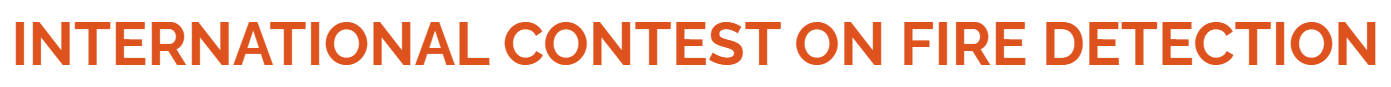

Dear Participant,

Thanks for your participation to ONFIRE Contest 2023.

Please download the following files:
- Training videos: https://drive.google.com/file/d/1tEz2wVQjPp1MjVHZLa-Z3uyVBnwljgGF/view?usp=sharing
- Training annotations: https://drive.google.com/file/d/123AcAQCldRNE6iKpXuCaVtsaR3uHIOeN/view?usp=sharing
- Code example: https://drive.google.com/file/d/1rXMCtpus2i2UDdSBD9RwWAxnT0wrrXOk/view?usp=sharing

Please remind that:
- The deadline for the submission of the methods is 21st July, 2023. The submission must be done with an email in which the participants share (directly or with external links) the trained model, the code and the report. The participants can receive the training set and its annotations by sending an email to onfire2023@unisa.it, in which they also communicate the name of the team.
- The participants can use these training samples and annotations, but also additional videos.
- The participants must submit their trained model and their code by carefully following the detailed instructions reported in the website. 
- The participants are strongly encouraged to submit a contest paper to ICIAP 2023, whose deadline is 28th July, 2023. The contest paper must be also sent by email to the organizers. Otherwise, the participants must produce a brief PDF report of the proposed method.
- The detailed instructions of the proposed method can be downloaded here: https://mivia.unisa.it/onfire2023/

In [ ]:
# You can follow this tutorial for more information - https://www.tutorialspoint.com/google_colab/index.htm
# You can also see this video - https://www.youtube.com/watch?v=inN8seMm7UI

# Mount your Drive - After doing this step, your Google Drive folders are accessible from Google Colab.
# from google.colab import drive
# drive.mount('/content/gdrive')
import os
import platform  

# Codice utile a Cristian per cambiare il path in base al sistema operativo e utilizzare GPU/MPS a seconda del caso
if platform.uname().node == "PC-Cristian":
    device = "cuda"
elif platform.uname().node == "Dell-G5-15-Alexios":
    print("Welcome Alexios!")
    device = "cuda"
    main_folder = os.getcwd()
elif platform.uname().node == "MacBook-Pro-di-Cristian.local":
    device = "mps"
else:
    pass

# Download and unzip

In [ ]:
import gdown

# Converte i link forniti in link scaricabili e li scarica nella cartella specificata.
def download_google_file(shader_url, output_name):
  id_url = "https://drive.google.com/uc?id=" + shader_url.split("/")[5]
  gdown.download(id_url, output_name)

In [ ]:
# Scarichiamo i video
mivia_videos = "https://drive.google.com/file/d/1tEz2wVQjPp1MjVHZLa-Z3uyVBnwljgGF/view?usp=sharing"
our_videos = "https://drive.google.com/file/d/1crTM4H7IsKyMHLRm-x4xuzSt2I0K39uj/view?usp=sharing"
download_google_file(our_videos, "VIDEOS.zip")
!mv VIDEOS.zip ../data
!unzip ../data/VIDEOS.zip

In [ ]:
# Scarichiamo le annotazioni
# Cambiamo i nomi delle directory per semplicità
# GT = Ground Truth

# Per i video classificati 0 il file di annotazione è vuoto 
# Per i video classificati 1 il file di annotazione non è vuoto e in una riga csv
# contiene l'indice del frame per cui per la prima volta l'operatore umano ha visto
# il fumo/fuoco

mivia_annotations = "https://drive.google.com/file/d/1tEz2wVQjPp1MjVHZLa-Z3uyVBnwljgGF/view?usp=sharing"
our_annotations = "https://drive.google.com/file/d/1ydxWtCXoC1q2qCP98kUUVkmP5dFaXe4q/view?usp=sharing"
download_google_file(our_annotations, "GT.zip")
!mv GT.zip ../data
!unzip ../data/GT.zip
!mkdir -p ../data/GT/TRAINING_SET
!mv ../data/GT_TRAINING_SET_CL0 ../data/GT/TRAINING_SET/0
!mv ../data/GT_TRAINING_SET_CL1 ../data/GT/TRAINING_SET/1

In [ ]:
# Scarichiamo il codice con i file di test
# Il modello deve essere tale da poter essere eseguibile con questo codice di
# test

download_google_file("https://drive.google.com/file/d/1rXMCtpus2i2UDdSBD9RwWAxnT0wrrXOk/view?usp=sharing", "test_code.zip")
!unzip test_code.zip

# Extract frames from video files

Riconduciamo il problema da un dominio di video ad un dominio di immagini andando a selezionare i frame di ogni video e disponendoli in una sottocartella. È importante salvare i frame con qualità alta, altrimenti distorciamo l'informazione data al classificatore.

In [ ]:
os.chdir("../data/")
train_videos_path = "TRAINING_SET"
test_videos_path = "TEST_SET"
val_videos_path = "VALIDATION_SET"
frames_path = "FRAMES"

In [ ]:
import os
import random
import shutil

def split_dataset(main_path, p = [0.8, 0.1, 0.1]):
    # Definisci il percorso della cartella originaria
    folder_path = main_path

    # Definisci il percorso delle nuove cartelle
    test_set_path = 'TEST_SET'
    validation_set_path = 'VALIDATION_SET'

    for folder in os.listdir(folder_path):
        if folder == ".DS_Store": continue
        # Crea le nuove cartelle
        os.makedirs(os.path.join(validation_set_path, folder), exist_ok=True)
        os.makedirs(os.path.join(test_set_path, folder), exist_ok=True)
        os.makedirs(os.path.join("GT", validation_set_path, folder), exist_ok=True)
        os.makedirs(os.path.join("GT", test_set_path, folder), exist_ok=True)
        
        # Leggi la lista dei video nella cartella originaria
        video_list = os.listdir(os.path.join(folder_path, folder))

        # Calcola il numero di video da assegnare a ciascuna cartella
        total_videos = len(video_list)
        training_set_size = int(total_videos * p[0])
        validation_set_size = int(total_videos * p[1])
        test_set_size = int(total_videos * p[2])

        # Genera l'indice casuale per mescolare la lista dei video
        random.shuffle(video_list)

        # QUELLI IN TRAINING RESTANO IN TRAINING

        # Copia i video nella cartella VALIDATION SET
        for video in video_list[training_set_size:training_set_size+validation_set_size]:
            src = os.path.join(folder_path, folder, video)
            dst = os.path.join(validation_set_path, folder, video)
            shutil.move(src, dst)
            video_ext = video.split(".")[-1]
            shutil.move(os.path.join("GT", src).replace(video_ext, "rtf"), os.path.join("GT", dst).replace(video_ext, "rtf"))

        # Copia i video nella cartella TEST SET
        for video in video_list[training_set_size+validation_set_size:]:
            src = os.path.join(folder_path, folder, video)
            dst = os.path.join(test_set_path, folder, video)
            shutil.move(src, dst)
            video_ext = video.split(".")[-1]
            shutil.move(os.path.join("GT", src).replace(video_ext, "rtf"), os.path.join("GT", dst).replace(video_ext, "rtf"))
            
split_dataset("TRAINING_SET")

In [ ]:
!rm -R FRAMES/TRAINING_SET/

We use ffmpeg to faster the frame extraction

In [ ]:
import cv2, os, argparse, glob, PIL, tqdm

def extract_frames(video):
    # Process the video
    ret = True
    cap = cv2.VideoCapture(video) # Decodifica lo streaming
    f = 0
    while ret:
        ret, img = cap.read() # Chiamando read leggiamo il frame successivo dallo stream
        if ret: # ret è false quando non ci sono più frame da leggere
            f += 1
            # Il tensore img letto viene trasformato tramite la classe PIL e lo salviamo
            PIL.Image.fromarray(img).save(os.path.join(frames_path, video, "{:05d}.jpg".format(f)))
    cap.release()

# For all the videos
for videos_path in ["TEST_SET", "VALIDATION_SET", "TRAINING_SET"]:
  file_list = [path for path in glob.glob(os.path.join(videos_path,"**"), recursive=True)
              if os.path.isfile(path)]
  print(file_list)
  for video in tqdm.tqdm(file_list):
    if os.path.isdir(os.path.join(frames_path, video)):
      continue
    
    os.makedirs(os.path.join(frames_path, video))
    # Versione lenta che utilizza la funzione definita prima
    #extract_frames(video) 
    # Versione veloce che fa uso della libreria ffmpeg
    os.system("ffmpeg -i {} -r 1/1 {}/{}/{}.jpg".format(video, frames_path, video, "%05d")) 



# PyTorch dataset

![](https://albumentations.ai/assets/img/custom/albumentations_logo.png)

We use [Albumentations](https://albumentations.ai/) to augment a set of frames with the same augmentation parameters.
![](https://albumentations.ai/assets/img/custom/top_image.jpg)

We use strprtf to parse RTF files

In [ ]:
!pip install striprtf

In [ ]:
import os
import os.path
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from typing import List, Union, Tuple, Any
from striprtf.striprtf import rtf_to_text
import albumentations

# Ci serve un codice che durante il training, una volta selezionato un video
# da cui caricare i frame, non va a prenderli tutti (potrebbero essere migliaia)
# ed il batch si riempirebbe di informazioni polarizzate ad uno stesso video

# Per ora mettiamoci nell'ipotesi semplice di caricare un solo frame nel video,
# ma credo che se si vuole usare una RNN non è questo il caso

# Se selezioniamo sempre il frame centrale, ad esempio, perdiamo la diversità (?) 38:33
# In fase di training conviene perché io voglio fornire alla mia rete campioni 
# differenti. Facendo molte epoche di training, andrò a coprire quasi tutti i frame
# di un certo video ed è una strategia che può funzionare in training
# In validation, devo capire se l'addestramento deve o non deve ancora andare 
# avanti, quindi scegliere elementi casuali e quindi avere un validation set che
# cambia ad ogni epoca andrebbe a sballare la loss rendendola poco confrontabile
# In validation (e quindi anche in test) per confrontare modelli diversi può avere
# senso fissarlo in maniera tale da averlo identico ad ogni epoca per avere un
# confronto basato sempre sugli stessi video

# Passo in avanti, vogliamo effettuare la classificazione sulla base di 3 frame
# consecutivi (o consecutivi e intervallati) per catturare la dinamicità (es.
# vedere qualcosa di rosso in movimento)
# Si noti che un po di augmentation la facciamo sempre, almeno un flip orizzontale
# che non ci introduce nessun problema, per cui se la facciamo randomicamente la devo 
# fare su tutti i 3 frame selezionati altrimenti potrebbe condurci a risultati errati
# Le augmentation, quindi, si applicano all'insieme dei frame selezionati per un dato video
# Alcune augmentation però hanno ancora senso nel singolo, ad esempio l'introduzione
# di un po di rumore applicato (simula un rumore di acquisizione che è 
# potenzialmente diverso ad ogni frame) a tale scopo si introduce ALMBUMENTATIONS
# un pacchetto di augmentation avanzata che consente di fare quello che si fa
# con torchvision ma anche di più.
# In particolare prende in input qualcosa di più strutturato che un semplice
# campione, ma magari un set di frame come serve a noi. Ma gestisce anche cose
# più complesse come la gestioen dei bounding box nell'object detection etc...


# NOTA: nei video il fuoco, se c'è, permane fino alla fine

class VideoRecord(object):
 # Sostanzilamente mantiene in memoria tutte le informazioni di annotazione di 
 # un particolare video 
    """
    Helper class for class VideoFrameDataset. This class
    represents a video sample's metadata.

    Args:
        root_datapath: the system path to the root folder of the videos.
        row: A list with four or more elements where
             1) The first element is the path to the video sample's frames excluding
             the root_datapath prefix
             2) The  second element is the starting frame id of the video
             3) The third element is the inclusive ending frame id of the video
             4) The fourth element is the label index.
             5) any following elements are labels in the case of multi-label classification
    """
    def __init__(self, row, root_datapath):
        # row = lista di interi che contiene:
        # 0: path del video
        # 1: primo frame del video (e qui dobbiamo decidere da dove partire)
        # 2: ultimo frame
        # 3: label della classe
        # 4: possono esserci altre annotazioni (es. fumo, fuoco)
        self._data = row
        self._path = os.path.join(root_datapath, row[0])

    @property
    def path(self) -> str:
        return self._path

    @property
    def num_frames(self) -> int:
        return self.end_frame - self.start_frame + 1  # +1 because end frame is inclusive

    @property
    def start_frame(self) -> int:
        return int(self._data[1])

    @property
    def end_frame(self) -> int:
        return int(self._data[2])

    @property
    def label(self) -> Union[int, List[int]]:
        # just one label_id
        if len(self._data) == 4:
            return int(self._data[3])
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._data[3:]]


class VideoFrameDataset(torch.utils.data.Dataset):
    r"""
    A highly efficient and adaptable dataset class for videos.
    Instead of loading every frame of a video,
    loads x RGB frames of a video (sparse temporal sampling) and evenly
    chooses those frames from start to end of the video, returning
    a list of x PIL images or ``FRAMES x CHANNELS x HEIGHT x WIDTH``
    tensors.

    More specifically, the frame range [START_FRAME, END_FRAME] is divided into NUM_SEGMENTS
    segments and FRAMES_PER_SEGMENT consecutive frames are taken from each segment.

    Note:
        A demonstration of using this class can be seen
        in ``demo.py``
        https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch

    Note:
        This dataset broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.

    Args:
        root_path: The root path in which video folders lie.
                   this is ROOT_DATA from the description above.
        num_segments: The number of segments the video should
                      be divided into to sample frames from.
        frames_per_segment: The number of frames that should
                            be loaded per segment. For each segment's
                            frame-range, a random start index or the
                            center is chosen, from which frames_per_segment
                            consecutive frames are loaded.
        imagefile_template: The image filename template that video frame files
                            have inside of their video folders as described above.
        transform: Transform pipeline that receives a list of numpy images/frames.
        test_mode: If True, frames are taken from the center of each
                   segment, instead of a random location in each segment.

    """
    def __init__(self,
                 root_path: str, # dove sono contenuti i frame estratti         #? Questo non introdurrebbe dipendenza tra i dati???
                 num_segments: int = 1, # divide il video da cui caricare i
                 # frame in un certo numero di sezioni della stessa durata.
                 frames_per_segment: int = 3, # frame estratti dal segmento in maniera (di default) a caso
                 imagefile_template: str='{:05d}.jpg', # pattern nome dei frame
                 transform=None, # pipeline di augmentation preprocessing
                 totensor=True, # lasciarlo sempre a True
                 test_mode: bool = False): # quanto True, i frame vengono presi 
                 # sempre nelle stesse posizioni. È quello che vogliamo fare 
                 # quando costruiamo dataset per test o validation
        super(VideoFrameDataset, self).__init__()

        self.root_path = root_path
        self.num_segments = num_segments
        self.frames_per_segment = frames_per_segment
        self.imagefile_template = imagefile_template
        self.test_mode = test_mode

        if transform is None:
            self.transform = None
        else:
            additional_targets = {}
            for i in range(self.num_segments * self.frames_per_segment - 1):
                additional_targets["image%d" % i] = "image"
            self.transform = albumentations.Compose([transform],
                                                    additional_targets=additional_targets,
                                                    p=1)
        self.totensor = totensor
        self.totensor_transform = ImglistOrdictToTensor()

        self._parse_annotationfile()
        self._sanity_check_samples()

    def _load_image(self, directory: str, idx: int) -> Image.Image:
        return np.asarray(Image.open(os.path.join(directory, self.imagefile_template.format(idx))).convert('RGB'))

    def _parse_annotationfile(self):
      # Usando l'organizzazione delle cartelle suggerita l'annotazione viene 
      # gestita in automatico. Per ogni file video il codice ricava la posizione
      # del rispettivo file rtf e fa il parsing del file per ricavare la GT
      # In particolare quando vede un video di classe 1, segna il primo frame di
      # avvistamento del fuoco e da lì in poi selezionarà i frame randomici, 
      # andando ad ignorare un'eventuale fase del video iniziale in cui il fuoco
      # non c'è
      # Fatto questo parse abbiamo costruito la label del video
        self.video_list = []
        for class_name in os.listdir(self.root_path):
            for video_name in os.listdir(os.path.join(self.root_path, class_name)):
                frames_dir = os.path.join(self.root_path, class_name, video_name)
                if os.path.isdir(frames_dir):
                    frame_path = os.path.join(class_name, video_name)
                    end_frame = len(os.listdir(frames_dir))

                    video_ext = frames_dir.split(".")[-1]
                    annotation_path = frames_dir\
                        .replace("\\", "/") \
                        .replace("FRAMES/", "GT/") \
                        .replace(video_ext, "rtf")

                    with open(annotation_path, 'r') as file:
                        text = rtf_to_text(file.read())
                    if len(text):
                        label = 1
                        start_frame = int(text.split(",")[0])
                        if start_frame == 0:
                          start_frame = 1
                    else:
                        label = 0
                        start_frame = 1

                    self.video_list.append(VideoRecord(
                        [frame_path, start_frame, end_frame, label],
                        self.root_path))

    def _sanity_check_samples(self):
      # Controllo delle annotazioni ricavate per ogni video
        for record in self.video_list:
            if record.num_frames <= 0 or record.start_frame == record.end_frame:
                print(f"\nDataset Warning: video {record.path} seems to have zero RGB frames on disk!\n")

            elif record.num_frames < (self.num_segments * self.frames_per_segment):
                print(f"\nDataset Warning: video {record.path} has {record.num_frames} frames "
                      f"but the dataloader is set up to load "
                      f"(num_segments={self.num_segments})*(frames_per_segment={self.frames_per_segment})"
                      f"={self.num_segments * self.frames_per_segment} frames. Dataloader will throw an "
                      f"error when trying to load this video.\n")

    def _get_start_indices(self, record: VideoRecord) -> 'np.ndarray[int]':
        """
        For each segment, choose a start index from where frames
        are to be loaded from.

        Args:
            record: VideoRecord denoting a video sample.
        Returns:
            List of indices of where the frames of each
            segment are to be loaded from.
        """
        # choose start indices that are perfectly evenly spread across the video frames.
        if self.test_mode:
            distance_between_indices = (record.num_frames - self.frames_per_segment + 1) / float(self.num_segments)

            start_indices = np.array([int(distance_between_indices / 2.0 + distance_between_indices * x)
                                      for x in range(self.num_segments)])
        # randomly sample start indices that are approximately evenly spread across the video frames.
        else:
            max_valid_start_index = (record.num_frames - self.frames_per_segment + 1) // self.num_segments

            start_indices = np.multiply(list(range(self.num_segments)), max_valid_start_index) + \
                      np.random.randint(max_valid_start_index, size=self.num_segments)

        return start_indices

    def __getitem__(self, idx: int) -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        For video with id idx, loads self.NUM_SEGMENTS * self.FRAMES_PER_SEGMENT
        frames from evenly chosen locations across the video.

        Args:
            idx: Video sample index.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """
        record: VideoRecord = self.video_list[idx]

        frame_start_indices: 'np.ndarray[int]' = self._get_start_indices(record)

        return self._get(record, frame_start_indices)

    def _get(self, record: VideoRecord, frame_start_indices: 'np.ndarray[int]') -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        Loads the frames of a video at the corresponding
        indices.

        Args:
            record: VideoRecord denoting a video sample.
            frame_start_indices: Indices from which to load consecutive frames from.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """

        frame_start_indices = frame_start_indices + record.start_frame
        images = list()

        # from each start_index, load self.frames_per_segment
        # consecutive frames
        for start_index in frame_start_indices:
            frame_index = int(start_index)

            # load self.frames_per_segment consecutive frames
            for _ in range(self.frames_per_segment):
                image = self._load_image(record.path, frame_index)
                images.append(image)

                if frame_index < record.end_frame:
                    frame_index += 1

        if self.transform is not None:
            transform_input = {"image": images[0]}
            for i, image in enumerate(images[1:]):
                transform_input["image%d" % i] = image
            images = self.transform(**transform_input)

        if self.totensor:
            images = self.totensor_transform(images)
        return images, record.label

    def __len__(self):
        return len(self.video_list)


class ImglistOrdictToTensor(torch.nn.Module):
    """
    Converts a list or a dict of numpy images to a torch.FloatTensor
    of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH).
    Can be used as first transform for ``VideoFrameDataset``.
    """
    @staticmethod
    def forward(img_list_or_dict):
        """
        Converts each numpy image in a list or a dict to
        a torch Tensor and stacks them into a single tensor.

        Args:
            img_list_or_dict: list or dict of numpy images.
        Returns:
            tensor of size ``NUM_IMAGES x CHANNELS x HEIGHT x WIDTH``
        """
        if isinstance(img_list_or_dict, list):
            return torch.stack([transforms.functional.to_tensor(img)
                                for img in img_list_or_dict])
        else:
            return torch.stack([transforms.functional.to_tensor(img_list_or_dict[k])
                                for k in img_list_or_dict.keys()])


Non viene fatto alcun controllo durante la selezione dei frame sul fatto che in fase di training un frame potrebbe essere scelto più volte. Non è un grande problema in quanto la probabilità che accada è molto bassa, e se succede la rete è molto diversa tra le due circostanze in cui uno stesso frame viene valutato. Inoltre, le augmentation potrebbero agire diversamente su quel frame.

Questo controllo potrebbe essere fatto ma complica di molto l'implementazione.

In [ ]:

def demo_visualization():
    from torchvision.utils import make_grid
    import matplotlib.pyplot as plt
    import  albumentations
    # Augmentation
    # OneOf prende in ingresso una lista di augmentation ed applica con una
    # certa probabilità solo una augmentation di questa lista (presa casualmente)
    # augmentation = albumentations.OneOf(
    #     [
    #     # albumentations.HorizontalFlip(p=1.),
    #     albumentations.ShiftScaleRotate(shift_limit=0., scale_limit=0.5, rotate_limit=0, p=1.),
    #     ],
    #     p=1)


        
    augmentation = albumentations.Compose([
        albumentations.Downscale(p=0), # Riduce la risoluzione
    ], p=1)
    # Dataset with augmentation for visualization
    dataset = VideoFrameDataset(root_path="../data/SPLITTED_FRAMES/TRAINING_SET/",
                                num_segments=1,
                                frames_per_segment=1,
                                transform=augmentation,
                                )
    counter = 0
    for X, y in dataset:
        if counter > 10:
            break
        plt.figure()
        plt.imshow(make_grid(X).numpy().transpose((1, 2, 0)))
        plt.title(y)
        plt.show()
        counter += 1



demo_visualization()

# Questa demo è utile per testare l'augumentation prima di far iniziare il
# training per un certo numero di ore

In [ ]:
def demo_training():
    # Preprocessing and augmentation
    # applica sempre, ha senso per il preprocessing
    preprocessing = albumentations.Sequential([
        albumentations.Resize(height=224, width=224, always_apply=True),
        albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225],
                                 max_pixel_value=255.,
                                 always_apply=True), 
    ])


    # Rispetto al preprocessing di alexnet, dove fecevamo un resize a 257 e un
    # crop centrale a 224, in questo caso facciamo un resize diretto perché i
    # dati non sono tali per cui l'oggetto di interesse è posizionato ben 
    # centrale e quindi andremmo a perdere informazioni facendo un crop

    augmentation = albumentations.OneOf([
        albumentations.HorizontalFlip(p=1.),
        ], p=.5)

    # Dataset for training
    dataset = VideoFrameDataset(root_path="FRAMES/TRAINING_SET/",
                                num_segments=1,
                                frames_per_segment=1,
                                transform=albumentations.Compose([
                                    preprocessing,
                                    augmentation],
                                    p=1.,
                                )
                                )

    print(dataset, "\nelements:", len(dataset))
    X, y = dataset[0]
    print('first element data', X.shape, X.min(), X.max(), X.mean(), X.std(),
          '\nlabel', y)
    return dataset

dataset_train = demo_training()

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, shuffle=True,
                              batch_size=2, num_workers=0, pin_memory=True)
print(dataloader_train, "\nbatches:", len(dataloader_train))

for X, y in tqdm(dataloader_train):
  print('batch data', X.shape, X.min(), X.max(), X.mean(), X.std(), '\nlabel', y)

# Per ricondurci ad un problema di classificazione di immagini, possiamo mettere
# ad 1 il frame ricevuto e fare un'operazione di squeeze()

In [ ]:
# cp -r FRAMES gdrive/MyDrive/Magistrale/